### columns info
 - ACADEMIC_STAT_CODE : 중도탈락 여부
 - ADMISSION : 입학 전형
 - AGE : 나이
 - ATTENDANCE : 출석률
 - DOUBLE_MAJOR : 복수전공 여부
 - GRADE : 평균학점
 - INCOME_QUINTILE: 소득분위(5분위)
 - OCCP_GRP_1 : 학과 계열
 - PREPARE_ATTENDANCE : 동일 나이 대비 출석률
 - PREPARE_GRADE : 동일 나이 대비 평균학점
 - PREPARE_join_1years_ago	PREPARE_join_2years_ago	PREPARE_join_3years_ago	PREPARE_join_4years_ago	PREPARE_join_this_year 
   : 동일나이 대비 년도별 교내 프로그램 참가 횟수
 - STUDENT_ID : 학생 고유 번호
 - TOTAL_JOIN : 교내프로그램 총 참가 횟수
 - TOTAL_OFF : 총 휴학 횟수
 - UNI_DIST : 거주지와 대학간의 거리
 - join_1years_ago join_2years_ago join_3years_ago join_4years_ago join_this_year
   : 년도별 교내프로그램 참가 횟수
 - off_1years_ago	off_2years_ago	off_3years_ago	off_4years_ago	off_this_year
   : 년도별 휴학 여부

## LIME의 결과
 - svc : 탈락(계열, 휴학여부, 입학전형, 복수전공여부)
 - knn : 탈락(계열, 휴학여부, 입학전형, 복수전공여부, 출석률) 
 - df : 탈락(교내프로그램 참가, 소득분위, 출석률, 휴학 횟수)
 - soft voting : 탈락(계열, 휴학여부, 복수전공여부, 입학전형, 교내프로그램 참가)

## SHAP 결과
 - svc : 입학전형, 복수전공, 계열, 휴학 여부, 출석률
 - knn : 계열, 소득분위, 출석률, 나이, 학점, 복수전공
 - df : 교내프로그램 참가, 소득분위, 학교와 거리, 학점, 출석률
 - soft vothing : 계열, 입학전형, 복수전공, 출석률, 휴학, 교내프로그램 참가, 소득분위, 학점

## 모델 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
inverse_data = pd.read_csv('./temp_data/save_inverse_data.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)

x_train = pd.read_csv('./temp_data/save_x_train.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
y_train = pd.read_csv('./temp_data/save_y_train.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
x_test_1st = pd.read_csv('./temp_data/save_x_test_1st.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
y_test_1st = pd.read_csv('./temp_data/save_y_test_1st.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)

In [3]:
from sklearn.model_selection import train_test_split

y_train = y_train.replace('탈락',1)
y_train = y_train.replace('유지',0)

y_test_1st = y_test_1st.replace('탈락',1)
y_test_1st = y_test_1st.replace('유지',0)

from imblearn.over_sampling import ADASYN

ads = ADASYN(random_state=42)
x_train_over,y_train_over = ads.fit_resample(x_train,y_train)

In [4]:
import pickle 
with open('./model/student_model_test.pickle','rb') as f:
    model = pickle.load(f)

## Explainable AI (XAI)

##### matplotlib 한글깨짐 해결

In [5]:
import matplotlib as mat
import matplotlib.font_manager as fonm

font_list = [font.name for font in fonm.fontManager.ttflist]
# for f in font_list:
#     print(f"{f}.ttf")

mat.rcParams['font.family'] = 'Hancom Gothic'

### LIME
 - voting에 사용된 각 모델별로 의사결정 요인을 시각화 한다.
 - 각 모델들의 의사결정 요인을 모두 합산하여 VotingClassifier모델의 의사결정 요인을 사각화한다. 

In [6]:
import lime
import lime.lime_tabular

#### voting에 이용된 모델들의 변수 중요도를 추출

In [7]:
predict_fn_estimators_0 = lambda x: model.estimators_[0].predict_proba(x).astype(float)

predict_fn_estimators_1 = lambda x: model.estimators_[1].predict_proba(x).astype(float)

predict_fn_estimators_2 = lambda x: model.estimators_[2].predict_proba(x).astype(float)

feature_names = list(x_train_over.columns)
class_names = ['유지', '탈락']

explainer = lime.lime_tabular.LimeTabularExplainer(training_data = x_train_over.values, feature_names=feature_names, training_labels=y_train_over.values ,\
                                                   class_names=class_names, discretize_continuous=True, random_state=42)

sample = len(x_test_1st) - 1

exp_estimators_0 = explainer.explain_instance(data_row = x_test_1st.values[sample], predict_fn = predict_fn_estimators_0, num_features=len(x_test_1st), num_samples=10000, top_labels=2)

exp_estimators_1 = explainer.explain_instance(data_row = x_test_1st.values[sample], predict_fn = predict_fn_estimators_1, num_features=len(x_test_1st), num_samples=10000, top_labels=2)

exp_estimators_2 = explainer.explain_instance(data_row = x_test_1st.values[sample], predict_fn = predict_fn_estimators_2, num_features=len(x_test_1st), num_samples=10000, top_labels=2)

exp_list = [exp_estimators_0, exp_estimators_1, exp_estimators_2]

#### html로 요약본을 저장

In [8]:
for i, exp in enumerate(exp_list):
    # exp.show_in_notebook(show_all=False)
    exp.save_to_file('./feature_importance_test/{}.html'.format(model.estimators_[i]))

#### voting에 이용된 모델들의 feature_importance 확인 및 각각의 의사결정의 주요 변수를 시각화

SVC(C=100, kernel='linear', probability=True, random_state=42)
KNeighborsClassifier(p=1)
DecisionTreeClassifier(random_state=42)


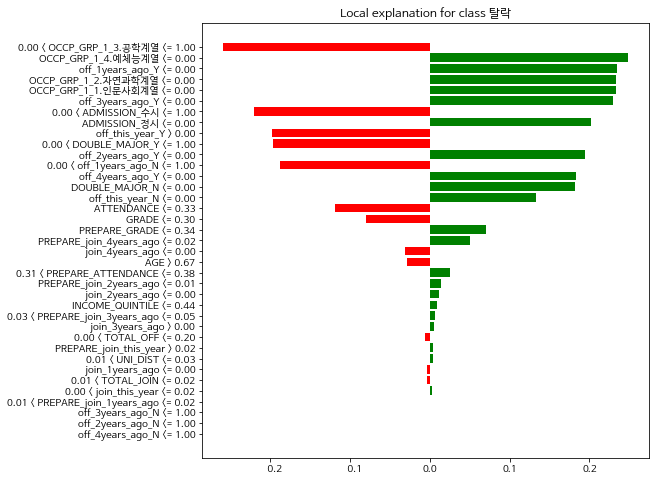

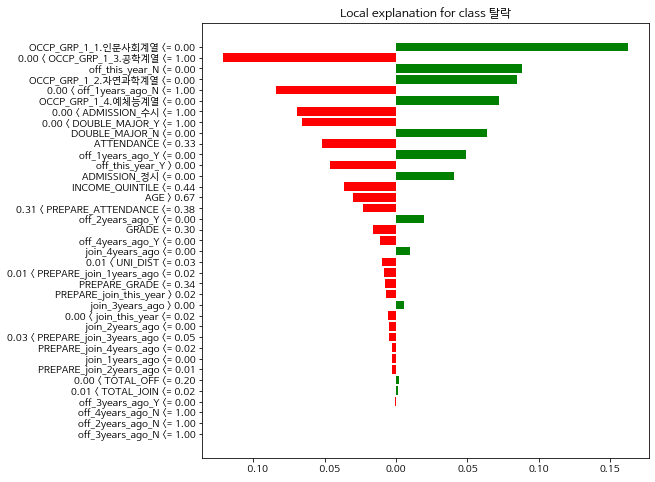

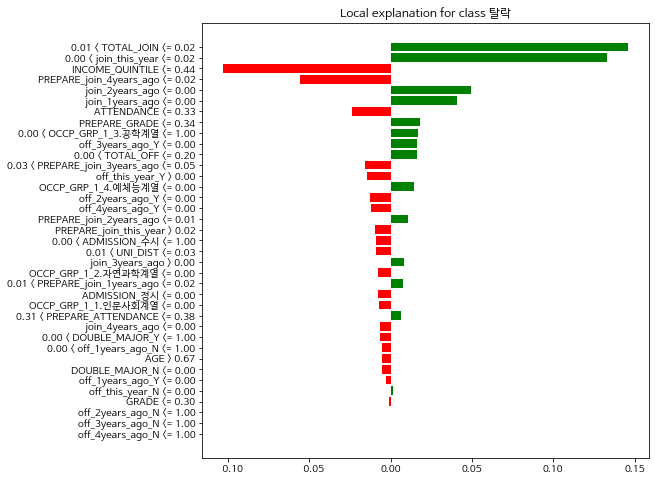

In [9]:
for i, exp in enumerate(exp_list):
    print(model.estimators_[i])
    flg1 = exp.as_pyplot_figure(label=1)
    flg1.set_size_inches(8, 8)
    flg1.show()

In [10]:
# inverse_condition = []
# inverse_range = len(inverse_data.columns)
# i_range = len(exp_estimators_0.as_list())
# inversed_dict = dict()

# for n in range(0,inverse_range):
#     for i in range(0,i_range):
        
#         if str(exp_estimators_0.as_list()[i][0].split(" ")[0]) == inverse_data.columns[n]:
#             inverse_condition = str(exp_estimators_0.as_list()[i][0])
#             target_col = str(inverse_condition.split(" ")[0])
#             target_num = float(inverse_condition.split(" ")[2])
#             target_oper = inverse_condition.split(" ")[1]

#             if target_oper == '<=':
#                 print("<=")
#                 inversed_dict[str(inverse_condition)] = real_feature.loc[real_feature[target_col] <= target_num]

#             elif target_oper == '>=':
#                 print(">=")
#                 inversed_dict[str(inverse_condition)] = real_feature.loc[real_feature[target_col] <= target_num]

#             elif target_oper == '<':
#                 print("<")
#                 inversed_dict[str(inverse_condition)] = real_feature.loc[real_feature[target_col] <= target_num]

#             elif target_oper == '>':    
#                 print(">")
#                 inversed_dict[str(inverse_condition)] = real_feature.loc[real_feature[target_col] <= target_num]

#             elif target_oper == '==':  
#                 print("==")
#                 inversed_dict[str(inverse_condition)] = real_feature.loc[real_feature[target_col] <= target_num]
                
#         if str(exp_estimators_0.as_list()[i][0].split(" ")[2]) == inverse_data.columns[n]:     
#             inverse_condition = str(exp_estimators_0.as_list()[i][0])
            
#             target_col = str(inverse_condition.split(" ")[2])
#             target_num_1 = float(inverse_condition.split(" ")[0])
#             target_num_2 = float(inverse_condition.split(" ")[4])
#             target_oper_1 = str(inverse_condition.split(" ")[1])
#             target_oper_2 = str(inverse_condition.split(" ")[3])

#             if (target_oper_1 == '<') & (target_oper_2 == '<='):
#                 print('<, <=')
#                 inversed_dict[str(inverse_condition)] = real_feature.loc[ (real_feature[target_col] > target_num_1) & (real_feature[target_col] <= target_num_2) ] 

#             elif (target_oper_1 == '<') & (target_oper_2 == '<'):
#                 print('<, <')
#                 inversed_dict[str(inverse_condition)] = real_feature.loc[ (real_feature[target_col] > target_num_1) & (real_feature[target_col] < target_num_2) ] 

#             elif (target_oper_1 == '<=') & (target_oper_2 == '<'):
#                 print('<=, <')
#                 inversed_dict[str(inverse_condition)] = real_feature.loc[ (real_feature[target_col] >= target_num_1) & (real_feature[target_col] < target_num_2) ] 

#             elif (target_oper_1 == '<=') & (target_oper_2 == '<='):
#                 print('<=, <=')
#                 inversed_dict[str(inverse_condition)] = real_feature.loc[ (real_feature[target_col] >= target_num_1) & (real_feature[target_col] <= target_num_2) ] 

#### VotingClassifier모델의 feature_importance 확인 및 의사결정의 주요 변수를 시각화

In [11]:
from operator import itemgetter
import operator

In [12]:
def sum_sentiment(x):
    init_dict = list(x)

    result = {}
    for d in init_dict:
        for k in d.keys():
            result[k] = result.get(k, 0) + d[k]
    return result

#### VotingClassifier에 사용된 각각의 모델들의 의사결정 수치를 합쳐서 3으로 나눔

In [13]:
feature_importance1 = dict()
for i in range(37):
    feature_importance1[str(exp_estimators_0.as_list()[i][0])] = exp_estimators_0.as_list()[i][1]

feature_importance2 = dict()
for i in range(37):
    feature_importance2[str(exp_estimators_1.as_list()[i][0])] = exp_estimators_1.as_list()[i][1]

feature_importance3 = dict()
for i in range(37):
    feature_importance3[str(exp_estimators_2.as_list()[i][0])] = exp_estimators_2.as_list()[i][1]

df_dic = pd.DataFrame({'sentiment' : [feature_importance1]})
df_dic = df_dic.append({'sentiment' : feature_importance2}, ignore_index=True)
df_dic = df_dic.append({'sentiment' : feature_importance3}, ignore_index=True)

dic_sum = df_dic.agg({'sentiment' : lambda x : sum_sentiment(x)})

sorted_dic_sum = sorted(dic_sum.values[0].items(), key=operator.itemgetter(1))

voting_df = pd.DataFrame(data=sorted_dic_sum, columns=['key','value'])

voting_df['value'] = voting_df['value']/3

#### scale되지 않는 데이터를 가져와서 feature_importance의 scale된 값을 변경해줌
 - ex. GRADE <= 0.3을 GRADE <= 2.5로 변경

In [14]:
inverse_condition = []
inverse_range = len(inverse_data.columns)
i_range = len(list(voting_df['key']))
inversed_dict = dict()

for n in range(0,inverse_range):
    for i in range(0,i_range):
        
        if str(list(voting_df['key'])[i].split(" ")[0]) == inverse_data.columns[n]:
            inverse_condition = str(list(voting_df['key'])[i])
            target_col = str(inverse_condition.split(" ")[0])
            target_num = float(inverse_condition.split(" ")[2])
            target_oper = inverse_condition.split(" ")[1]

            if target_oper == '<=':
                inversed_dict[str(inverse_condition)] = x_train.loc[x_train[target_col] <= target_num]

            elif target_oper == '>=':
                inversed_dict[str(inverse_condition)] = x_train.loc[x_train[target_col] <= target_num]

            elif target_oper == '<':
                inversed_dict[str(inverse_condition)] = x_train.loc[x_train[target_col] <= target_num]

            elif target_oper == '>':    
                inversed_dict[str(inverse_condition)] = x_train.loc[x_train[target_col] <= target_num]

            elif target_oper == '==':  
                inversed_dict[str(inverse_condition)] = x_train.loc[x_train[target_col] <= target_num]
                
        if str(list(voting_df['key'])[i].split(" ")[2]) == inverse_data.columns[n]:     
            inverse_condition = str(list(voting_df['key'])[i])
            
            target_col = str(inverse_condition.split(" ")[2])
            target_num_1 = float(inverse_condition.split(" ")[0])
            target_num_2 = float(inverse_condition.split(" ")[4])
            target_oper_1 = str(inverse_condition.split(" ")[1])
            target_oper_2 = str(inverse_condition.split(" ")[3])

            if (target_oper_1 == '<') & (target_oper_2 == '<='):
                inversed_dict[str(inverse_condition)] = x_train.loc[ (x_train[target_col] > target_num_1) & (x_train[target_col] <= target_num_2) ] 

            elif (target_oper_1 == '<') & (target_oper_2 == '<'):
                inversed_dict[str(inverse_condition)] = x_train.loc[ (x_train[target_col] > target_num_1) & (x_train[target_col] < target_num_2) ] 

            elif (target_oper_1 == '<=') & (target_oper_2 == '<'):
                inversed_dict[str(inverse_condition)] = x_train.loc[ (x_train[target_col] >= target_num_1) & (x_train[target_col] < target_num_2) ] 

            elif (target_oper_1 == '<=') & (target_oper_2 == '<='):
                inversed_dict[str(inverse_condition)] = x_train.loc[ (x_train[target_col] >= target_num_1) & (x_train[target_col] <= target_num_2) ] 

inversed_dict_values = list(inversed_dict.values())

i_range = len(inversed_dict_values)
j_range = len(voting_df['key'])


for i in range(0, i_range):
    for j in range(0, j_range):
        temp_list = voting_df['key'][j].split(" ")
        
        if temp_list[0] == inverse_data.columns[i]:
            target_value = inversed_dict_values[i][temp_list[0]].max()
            result_value = round( list( inverse_data.loc[ inversed_dict_values[i].loc[ inversed_dict_values[i][temp_list[0]] == target_value ].index ][temp_list[0]] )[0], 2)
            
            temp_list[2] = str(result_value)
            temp_result = " ".join(temp_list)
            voting_df['key'][j] = temp_result
            
        if temp_list[2] == inverse_data.columns[i]:
            target_value_max = inversed_dict_values[i][temp_list[2]].max()
            result_value_max = round( list( inverse_data.loc[ inversed_dict_values[i].loc[ inversed_dict_values[i][temp_list[2]] == target_value_max ].index ][temp_list[2]] )[0], 2)

            target_value_min = inversed_dict_values[i][temp_list[2]].min()
            result_value_min = round( list( inverse_data.loc[ inversed_dict_values[i].loc[ inversed_dict_values[i][temp_list[2]] == target_value_min ].index ][temp_list[2]] )[0], 2)
            
            temp_list[0] = str(result_value_min)
            temp_list[4] = str(result_value_max)
            
            temp_result = " ".join(temp_list)
            voting_df['key'][j] = temp_result

#### 시각화
 - 노란색 막대그래프는 voting모델이 중도탈락자를 예측할 때 사용하는 주요원인이다.

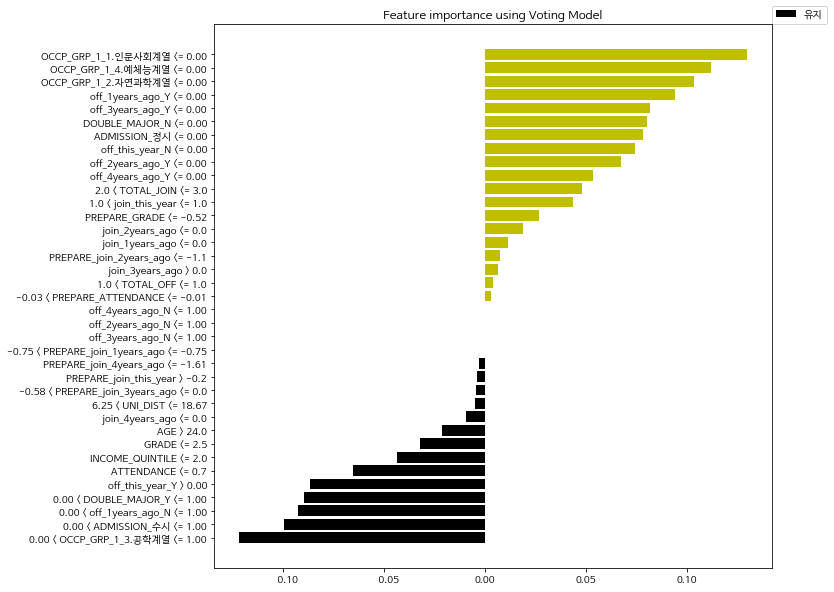

In [15]:
voting_df.set_index(keys='key',inplace=True)

voting_df.sort_values('value', ascending=True, inplace=True)

plt.rcParams["figure.figsize"] = (10,10)
col = np.where(voting_df['value']<0,'k','y')
plt.barh(voting_df.index, voting_df['value'], color=col, label='유지')
plt.title("Feature importance using Voting Model")
plt.legend(loc=(1, 1))
plt.show()

## SHAP

In [17]:
import shap
import skimage
print(skimage.__version__)

0.18.1


#### 모델 확인

In [18]:
model.estimators_

[SVC(C=100, kernel='linear', probability=True, random_state=42),
 KNeighborsClassifier(p=1),
 DecisionTreeClassifier(random_state=42)]

#### KernelExplainer의 속도이슈로 data row를 줄임

In [31]:
X_train_summary = shap.kmeans(x_train_over, 5)

#### 모델 별로 shap_values를 만들어 저장

In [32]:
explainer_svc = shap.KernelExplainer(model=model.estimators_[0].predict_proba, data=X_train_summary.data)

shap_values_svc = explainer_svc.shap_values(x_test_1st)

shap_values_svc_df = pd.concat([pd.DataFrame(shap_values_svc[0]), pd.DataFrame(shap_values_svc[1])],axis=0)

shap_values_svc_df.to_csv('./shap_test/shap_values_svc_df.csv',index = True)

In [18]:
explainer_knn = shap.KernelExplainer(model=model.estimators_[1].predict_proba, data=X_train_summary.data)

shap_values_knn = explainer_knn.shap_values(x_test_1st)

shap_values_knn_df = pd.concat([pd.DataFrame(shap_values_knn[0]), pd.DataFrame(shap_values_knn[1])],axis=0)

shap_values_knn_df.to_csv('./shap_test/shap_values_knn_df.csv',index = True)

In [16]:
explainer_dt = shap.TreeExplainer(model.estimators_[2])

shap_values_dt = explainer_dt.shap_values(x_test_1st)

shap_values_dt_df = pd.concat([pd.DataFrame(shap_values_dt[0]), pd.DataFrame(shap_values_dt[1])],axis=0)

shap_values_dt_df.to_csv('./shap_test/shap_values_dt_df.csv',index = True)

In [45]:
shap.initjs() # javascript 초기화 (graph 초기화)

#### 각 모델의 shap_values를 가져와 탈락에 해당하는 데이터만 추출하여 시각화

In [22]:
shap_values_svc_df = pd.read_csv('./shap_test/shap_values_svc_df.csv',\
                                 encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
shap_values_knn_df = pd.read_csv('./shap_test/shap_values_knn_df.csv',\
                                 encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
shap_values_dt_df = pd.read_csv('./shap_test/shap_values_dt_df.csv',\
                                 encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)

shap_values_svc_Y = shap_values_svc_df.iloc[2061:,:]
shap_values_knn_df_Y = shap_values_knn_df.iloc[2061:,:]
shap_values_dt_df_Y = shap_values_dt_df.iloc[2061:,:]

#### 모델 개별 의사결정 주요도 시각화
 - svc만 예제로

In [50]:
shap.force_plot(explainer_svc.expected_value[1], shap_values_svc_Y.values[201,:], x_test_1st.iloc[201,:])

#### 각 모델 전체 의사결정 주요도 시각화

SVC(C=100, kernel='linear', probability=True, random_state=42)


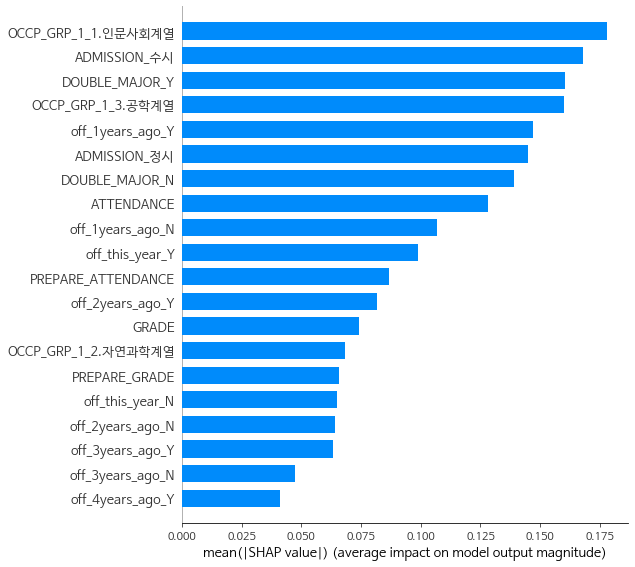

None

KNeighborsClassifier(p=1)


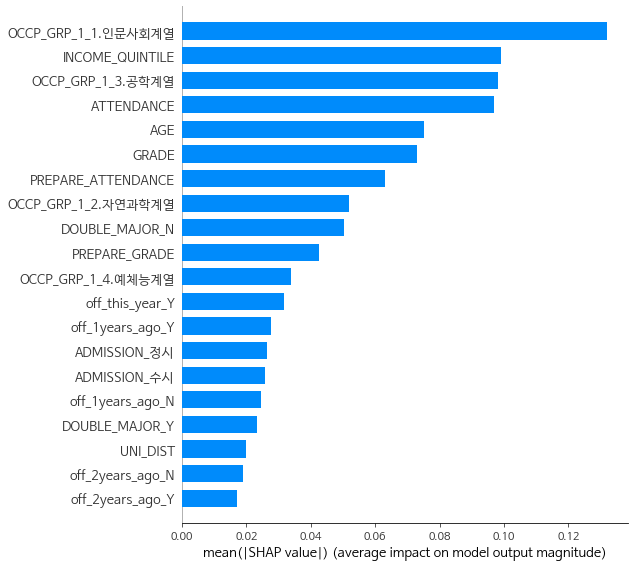

None

DecisionTreeClassifier(random_state=42)


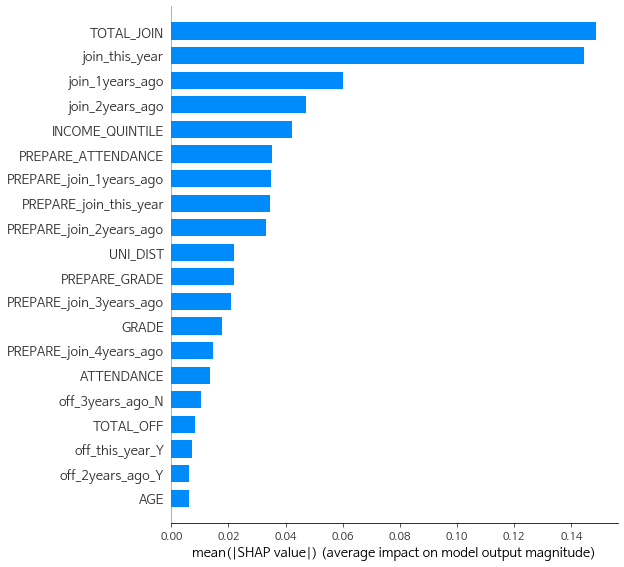

None


In [27]:
print(model.estimators_[0])
print(shap.summary_plot(shap_values=shap_values_svc_Y.values, features=x_test_1st, plot_type='bar'))
print()
print(model.estimators_[1])
print(shap.summary_plot(shap_values=shap_values_knn_df_Y.values, features=x_test_1st, plot_type='bar'))
print()
print(model.estimators_[2])
print(shap.summary_plot(shap_values=shap_values_dt_df_Y.values, features=x_test_1st, plot_type='bar'))

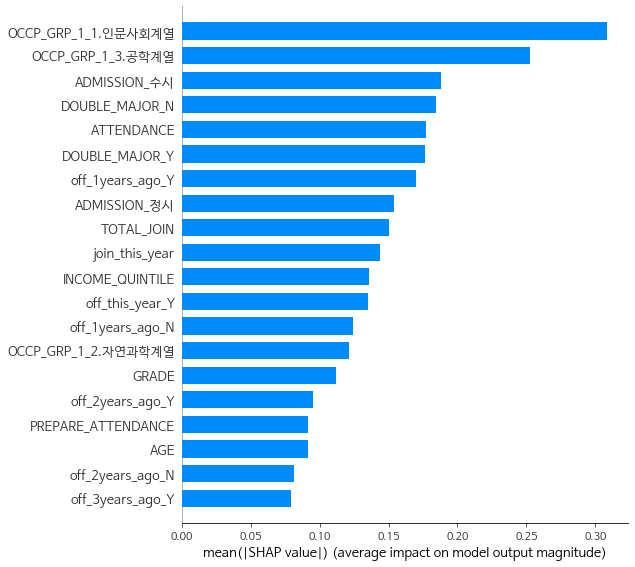

In [61]:
shap_values_voting_Y = shap_values_svc_Y + shap_values_knn_df_Y + shap_values_dt_df_Y

shap.summary_plot(shap_values=shap_values_voting_Y.values, features=x_test_1st, plot_type='bar')

## feature extraction
 - 동일나이 대비 년도별 교내 프로그램 참가 횟수 : 삭제
 - 년도별 교내프로그램 참가 횟수 : 3, 4년전 삭제
 - 년도별 휴학 여부 : 3, 4년전 삭제
 - 거주지와 대학간의 거리 : 삭제
 - 총 12개 삭제

In [64]:
x_train_feature = pd.concat([x_train,x_test_1st], axis=0)

y_train_feature = pd.concat([y_train,y_test_1st], axis=0)

In [76]:
x_train_feature.drop(['PREPARE_join_1years_ago', 'PREPARE_join_2years_ago', 'PREPARE_join_3years_ago', 'PREPARE_join_4years_ago',\
                      'PREPARE_join_this_year', 'UNI_DIST', 'join_3years_ago', 'join_4years_ago', 'off_3years_ago_N',\
                      'off_3years_ago_Y', 'off_4years_ago_N', 'off_4years_ago_Y'], axis=1, inplace=True)

In [77]:
x_train_feature.to_csv('./temp_data/x_train_feature.csv',index = True)
y_train_feature.to_csv('./temp_data/y_train_feature.csv',index = True)